In [ ]:
import zipfile
import os

In [ ]:
# Step 3: Extract the zip file
# Create a directory for extraction
extract_dir = "/content/train"
os.makedirs(extract_dir, exist_ok=True)

# Open and extract the zip file
with zipfile.ZipFile("train.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Contents extracted to {extract_dir}")

Contents extracted to /content/train


In [ ]:
# Step 3: Extract the zip file
# Create a directory for extraction
extract_dir = "/content/test"
os.makedirs(extract_dir, exist_ok=True)

# Open and extract the zip file
with zipfile.ZipFile("test.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Contents extracted to {extract_dir}")

Contents extracted to /content/test


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import random_split

# Set device (GPU if available)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
# Define transformations for the training and test datasets
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet mean/std
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [48]:
# Load datasets
train_dataset = datasets.ImageFolder(root='/content/train/train', transform=train_transforms)
test_dataset = datasets.ImageFolder(root='/content/test/test', transform=test_transforms)

In [49]:

# Split training data into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

In [50]:

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [51]:
# Define the CNN model architecture (no modular code)
conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
fc1 = nn.Linear(128 * 16 * 16, 512)
fc2 = nn.Linear(512, 5)  # 5 classes (cycling, dancing, drinking, eating, sitting)


In [52]:
# Initialize the model
model = nn.Sequential(
    conv1,
    nn.ReLU(),
    pool,
    conv2,
    nn.ReLU(),
    pool,
    conv3,
    nn.ReLU(),
    pool,
    nn.Flatten(),
    fc1,
    nn.ReLU(),
    fc2,
    nn.Softmax()
)


In [53]:


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [54]:
# Training the model
num_epochs = 1
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    total = 0
    correct = 0


    for inputs, labels in train_loader:
        #inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/1], Loss: 1.5405, Accuracy: 33.65%


In [26]:

# Evaluate the model on the validation set
model.eval()  # Set the model to evaluation mode
val_correct = 0
val_total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        #inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_accuracy = 100 * val_correct / val_total
print(f'Validation Accuracy: {val_accuracy:.2f}%')

Validation Accuracy: 49.30%


In [27]:


# Evaluate on the test set
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        #inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 55.08%


In [30]:
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.64      0.77      0.70       126
           1       0.62      0.28      0.38       126
           2       0.52      0.65      0.58       126
           3       0.49      0.72      0.59       126
           4       0.54      0.33      0.41       126

    accuracy                           0.55       630
   macro avg       0.56      0.55      0.53       630
weighted avg       0.56      0.55      0.53       630



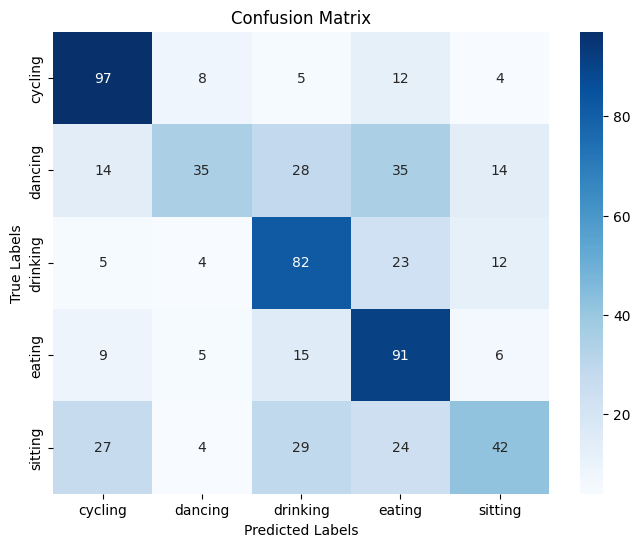

Test Accuracy: 55.08%


In [31]:
# Evaluate on the test set and generate confusion matrix
model.eval()
test_labels = []
test_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        #inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        test_labels.extend(labels.cpu().numpy())  # Collect true labels
        test_predictions.extend(predicted.cpu().numpy())  # Collect predicted labels

# Generate the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
cr=classification_report(test_labels, test_predictions)

print(cr)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print the test accuracy
test_accuracy = 100 * sum(np.array(test_labels) == np.array(test_predictions)) / len(test_labels)
print(f'Test Accuracy: {test_accuracy:.2f}%')


In [ ]:
# Hyperparameters to tune
learning_rates = [0.001, 0.01]
batch_sizes = [16, 32]
dropout_rates = [0.3, 0.5]
hidden_layers = [1, 2,3]  # 1 hidden layer or 2 hidden layers
hidden_units = [128, 256]  # Size of each hidden layer
num_epochs = 10

# Placeholder for the best model and hyperparameters
best_model = None
best_accuracy = 0
best_params = {}

# Grid search loop over hyperparameters
for lr in learning_rates:
    for batch_size in batch_sizes:
        for dropout_rate in dropout_rates:
            for num_hidden_layers in hidden_layers:
                for hidden_units_per_layer in hidden_units:

                    # Recreate data loaders with the current batch size
                    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
                    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
                    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

                    # Define the CNN model architecture with the current number of hidden layers and dropout rate
                    conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
                    conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
                    conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
                    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
                    fc_layers = []

                    # Create hidden layers based on the number of hidden layers
                    input_size = 128 * 16 * 16  # Image size after convolution and pooling
                    for i in range(num_hidden_layers):
                        fc_layers.append(nn.Linear(input_size, hidden_units_per_layer))
                        fc_layers.append(nn.ReLU())
                        fc_layers.append(nn.Dropout(dropout_rate))
                        input_size = hidden_units_per_layer  # Update input size for the next layer

                    fc_layers.append(nn.Linear(input_size, 5))  # Output layer for 5 classes (cycling, dancing, drinking, eating, sitting)

                    # Combine layers into a model
                    model = nn.Sequential(
                        conv1,
                        nn.ReLU(),
                        pool,
                        conv2,
                        nn.ReLU(),
                        pool,
                        conv3,
                        nn.ReLU(),
                        pool,
                        nn.Flatten(),
                        *fc_layers
                    ).to(device)

                    # Define the loss function and optimizer for this combination of hyperparameters
                    criterion = nn.CrossEntropyLoss()
                    optimizer = optim.Adam(model.parameters(), lr=lr)

                    # Train the model
                    for epoch in range(num_epochs):
                        model.train()
                        running_loss = 0.0
                        correct = 0
                        total = 0

                        for inputs, labels in train_loader:
                            inputs, labels = inputs.to(device), labels.to(device)

                            optimizer.zero_grad()
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                            loss.backward()
                            optimizer.step()

                            running_loss += loss.item()
                            _, predicted = torch.max(outputs, 1)
                            total += labels.size(0)
                            correct += (predicted == labels).sum().item()

                        epoch_loss = running_loss / len(train_loader)
                        epoch_accuracy = 100 * correct / total
                        print(f"Epoch [{epoch+1}/{num_epochs}] for lr={lr}, batch_size={batch_size}, dropout={dropout_rate}, hidden_layers={num_hidden_layers}, hidden_units={hidden_units_per_layer}: Loss={epoch_loss:.4f}, Accuracy={epoch_accuracy:.2f}%")

                    # Evaluate on the validation set after training
                    model.eval()
                    val_correct = 0
                    val_total = 0
                    with torch.no_grad():
                        for inputs, labels in val_loader:
                            inputs, labels = inputs.to(device), labels.to(device)
                            outputs = model(inputs)
                            _, predicted = torch.max(outputs, 1)
                            val_total += labels.size(0)
                            val_correct += (predicted == labels).sum().item()

                    val_accuracy = 100 * val_correct / val_total
                    print(f"Validation Accuracy for lr={lr}, batch_size={batch_size}, dropout={dropout_rate}, hidden_layers={num_hidden_layers}, hidden_units={hidden_units_per_layer}: {val_accuracy:.2f}%")


Epoch [1/10] for lr=0.001, batch_size=16, dropout=0.3, hidden_layers=1, hidden_units=128: Loss=1.4532, Accuracy=37.85%
Epoch [2/10] for lr=0.001, batch_size=16, dropout=0.3, hidden_layers=1, hidden_units=128: Loss=1.1421, Accuracy=55.95%
Epoch [3/10] for lr=0.001, batch_size=16, dropout=0.3, hidden_layers=1, hidden_units=128: Loss=0.9686, Accuracy=63.10%
Epoch [4/10] for lr=0.001, batch_size=16, dropout=0.3, hidden_layers=1, hidden_units=128: Loss=0.8091, Accuracy=69.12%
Epoch [5/10] for lr=0.001, batch_size=16, dropout=0.3, hidden_layers=1, hidden_units=128: Loss=0.6530, Accuracy=74.19%
Epoch [6/10] for lr=0.001, batch_size=16, dropout=0.3, hidden_layers=1, hidden_units=128: Loss=0.5074, Accuracy=81.41%
Epoch [7/10] for lr=0.001, batch_size=16, dropout=0.3, hidden_layers=1, hidden_units=128: Loss=0.3770, Accuracy=86.06%
Epoch [8/10] for lr=0.001, batch_size=16, dropout=0.3, hidden_layers=1, hidden_units=128: Loss=0.2729, Accuracy=90.30%
Epoch [9/10] for lr=0.001, batch_size=16, dropou

KeyboardInterrupt: 

# **Model Building with RESNET**

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models import resnet18

# Define the data augmentation transforms and normalization
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet mean/std
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets from directories (assuming images are organized in class-wise directories)
train_dataset = datasets.ImageFolder(root='/content/train/train', transform=transform_train)
test_dataset = datasets.ImageFolder(root='/content/test/test', transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define a simple CNN model (using ResNet18 as a starting point)
model = resnet18(pretrained=True)  # Using pre-trained ResNet18
num_ftrs = model.fc.in_features  # The number of input features to the final fully connected layer
model.fc = nn.Linear(num_ftrs, 5)  # We have 5 classes, so change the final layer

# Move the model to GPU if available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 1  # Define the number of epochs

for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        #inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

# Evaluate the model
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/1, Loss: 1.1738, Accuracy: 55.57%
Test Accuracy: 58.41%


tensor(1.1178, grad_fn=<NllLossBackward0>)

# **Data Augmentation**

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set device (GPU if available)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for the training and test datasets with data augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(128),  # Random crop and resize to 128x128
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(20),      # Random rotation of up to 20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet mean/std
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root='path_to_train_data', transform=train_transforms)
test_dataset = datasets.ImageFolder(root='path_to_test_data', transform=test_transforms)

# Split training data into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Hyperparameters to tune
learning_rates = [0.001, 0.01]
batch_sizes = [16, 32]
dropout_rates = [0.3, 0.5]
hidden_layers = [1, 2]  # 1 hidden layer or 2 hidden layers
hidden_units = [128, 256]  # Size of each hidden layer
num_epochs = 10

# Placeholder for the best model and hyperparameters
best_model = None
best_accuracy = 0
best_params = {}

# Grid search loop over hyperparameters
for lr in learning_rates:
    for batch_size in batch_sizes:
        for dropout_rate in dropout_rates:
            for num_hidden_layers in hidden_layers:
                for hidden_units_per_layer in hidden_units:

                    # Recreate data loaders with the current batch size
                    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
                    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
                    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

                    # Define the CNN model architecture with the current number of hidden layers and dropout rate
                    conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
                    conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
                    conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
                    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
                    fc_layers = []

                    # Create hidden layers based on the number of hidden layers
                    input_size = 128 * 16 * 16  # Image size after convolution and pooling
                    for i in range(num_hidden_layers):
                        fc_layers.append(nn.Linear(input_size, hidden_units_per_layer))
                        fc_layers.append(nn.ReLU())
                        fc_layers.append(nn.Dropout(dropout_rate))
                        input_size = hidden_units_per_layer  # Update input size for the next layer

                    fc_layers.append(nn.Linear(input_size, 5))  # Output layer for 5 classes (cycling, dancing, drinking, eating, sitting)

                    # Combine layers into a model
                    model = nn.Sequential(
                        conv1,
                        nn.ReLU(),
                        pool,
                        conv2,
                        nn.ReLU(),
                        pool,
                        conv3,
                        nn.ReLU(),
                        pool,
                        nn.Flatten(),
                        *fc_layers
                    ).to(device)

                    # Define the loss function and optimizer for this combination of hyperparameters
                    criterion = nn.CrossEntropyLoss()
                    optimizer = optim.Adam(model.parameters(), lr=lr)

                    # Train the model
                    for epoch in range(num_epochs):
                        model.train()
                        running_loss = 0.0
                        correct = 0
                        total = 0

                        for inputs, labels in train_loader:
                            inputs, labels = inputs.to(device), labels.to(device)

                            optimizer.zero_grad()
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                            loss.backward()
                            optimizer.step()

                            running_loss += loss.item()
                            _, predicted = torch.max(outputs, 1)
                            total += labels.size(0)
                            correct += (predicted == labels).sum().item()

                        epoch_loss = running_loss / len(train_loader)
                        epoch_accuracy = 100 * correct / total
                        print(f"Epoch [{epoch+1}/{num_epochs}] for lr={lr}, batch_size={batch_size}, dropout={dropout_rate}, hidden_layers={num_hidden_layers}, hidden_units={hidden_units_per_layer}: Loss={epoch_loss:.4f}, Accuracy={epoch_accuracy:.2f}%")

                    # Evaluate on the validation set after training
                    model.eval()
                    val_correct = 0
                    val_total = 0
                    with torch.no_grad():
                        for inputs, labels in val_loader:
                            inputs, labels = inputs.to(device), labels.to(device)
                            outputs = model(inputs)
                            _, predicted = torch.max(outputs, 1)
                            val_total += labels.size(0)
                            val_correct += (predicted == labels).sum().item()

                    val_accuracy = 100 * val_correct / val_total
                    print(f"Validation Accuracy for lr={lr}, batch_size={batch_size}, dropout={dropout_rate}, hidden_layers={num_hidden_layers}, hidden_units={hidden_units_per_layer}: {val_accuracy:.2f}%")

                    # Check if the current model is the best
                    if val_accuracy > best_accuracy:
                        best_accuracy = val_accuracy
                        best_model = model
                        best_params = {'lr': lr, 'batch_size': batch_size, 'dropout_rate': dropout_rate,
                                       'num_hidden_layers': num_hidden_layers, 'hidden_units_per_layer': hidden_units_per_layer}

# Final evaluation on the test set for the best model
model = best_model
test_labels = []
test_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        test_labels.extend(labels.cpu().numpy())  # Collect true labels
        test_predictions.extend(predicted.cpu().numpy())  # Collect predicted labels

# Generate the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print the best hyperparameters and test accuracy
test_accuracy = 100 * sum(np.array(test_labels) == np.array(test_predictions)) / len(test_labels)
print(f"Best Hyperparameters: {best_params}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


tensor([[-1.2976, -3.9306, -1.3261,  6.1125,  0.9774],
        [-1.1688, -4.0157, -1.5281,  5.6698,  1.9051],
        [ 0.3058, -0.6298, -2.1151,  3.2806,  0.1631],
        [-3.4606, -1.8910, -2.2786,  7.4812,  1.9043],
        [-0.5415, -1.9025, -2.4029,  5.2355,  0.4986],
        [ 2.0239, -0.5392, -3.6341,  0.9585,  1.6941],
        [ 1.8715, -3.5300, -1.4561,  1.2266,  2.4974],
        [-2.4469, -2.9936, -1.5861,  6.7212,  1.3572],
        [-2.7928, -2.9025, -0.5059,  5.4754,  1.4820],
        [ 0.0389, -1.3042, -1.8090,  1.0159,  1.5178],
        [ 2.0995, -1.5713, -1.4399, -0.1538,  0.8535],
        [ 3.8153, -1.3857, -2.7225, -1.1230,  1.8713],
        [ 0.0121, -2.1671, -2.1334,  3.1590,  1.8415],
        [ 0.6926, -1.9873, -0.8021,  1.6959,  0.9335],
        [-1.4957, -1.9689, -1.0461,  3.0491,  1.5829],
        [-1.3876, -2.1768, -0.4539,  2.2367,  1.6218],
        [-2.2989, -4.6137, -1.2547,  7.6312,  1.5405],
        [-0.1217, -1.0609, -1.1240,  1.7728,  0.5388],
        [-